In [51]:
from __future__ import division
from astropy.io import fits
import os,glob,sys
import glob
import copy
import numpy as np
from astropy.table import Table, Column
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
import lineid_plot


l_w = [3610.51,3650.15,4046.56,4358.33,4678.16,4799.92,5085.82,5460.74,5769.59,5790.65,5875.62]
l_l = ['Cd I', 'Hg I', 'Hg I','Hg I', 'Cd I' , 'Cd I', 'Cd I', 'Hg I', 'Hg I', 'Hg I', 'He']

In [11]:
# define path
path = '/Users/runquanguan/Documents/136P3/Mix'

In [12]:
os.chdir(path)
filename = glob.glob('*')

In [13]:
def get_bias(folder):
    Bias = []
    ARRAY = []
    # pick out bias frame
    for file in folder:
        hdul = fits.open(file)
        TYPE = hdul[0].header['OBJECT']
        if TYPE == 'bias':
            Bias.append(file)
        else:
            pass
            
    # extract data array from data 
    for file in Bias:
        hdul_b = fits.open(file)
        array = hdul_b[0].data
        # form arrays as a list
        ARRAY.append(array[80:2650,100:400])
    # turn list into array again to sum up
    ARRAY = np.array(ARRAY)
    # sum up
    SUM = ARRAY.sum(axis=0)
    # average out
    AVG = SUM/len(ARRAY)
    # return result
    return AVG


def Flat(folder):
    
    L = []
    ARRAY = []
    bias_frame = get_bias(folder)

    for file in folder:
        hdul = fits.open(file)
        header = hdul[0].header
        FRAME = hdul[0].header['OBJECT']  
        if FRAME=='dome_flat':
            L.append(file)
    # Flat = (file-dark-bias)/EXPT
    for file in L:
        hdul = fits.open(file)
        array = hdul[0].data
        ARRAY.append(array[80:2650,100:400])
        
    ARRAY = np.array(ARRAY)
    SUM = ARRAY.sum(axis=0)
    AVG = SUM/len(ARRAY)
    FLAT = (AVG - bias_frame)/10
    FLAT = FLAT/np.mean(FLAT)
    return FLAT

In [14]:
def reduce_frame(folder):
    
    L = []
    Reduced = []
    
    # define bias frame
    bias_frame = get_bias(folder)
    Flat_frame = Flat(folder)
    
    # find B science frame
    for file in folder:
        hdul = fits.open(file)
        header = hdul[0].header
        FRAME = hdul[0].header['OBJECT']  
        EXPT = hdul[0].header['EXPTIME']
        if FRAME=='arc':
            L.append(file)
        else:
            pass
             
    for file in L:
        hdul = fits.open(file)
        image_data = hdul[0].data[80:2650,100:400]
        image_header = hdul[0].header
        
        DATA = (image_data - bias_frame) / Flat_frame
        new_file = file[0:5]+"_RDU"+file[5:9]
        outhdu = fits.PrimaryHDU(data = DATA, header = image_header)
        outhdu.writeto(new_file,overwrite=True)
        
        Reduced.append(new_file)
    return Reduced

In [37]:
stacked_data = fits.getdata('stacked.fits')

In [69]:
spectrum2D = stacked_data
spectrum1D = np.mean(sci_2D,axis=1)

spectrum1D_list = list(spectrum1D)
list1 = list(spectrum1D)
list1.sort() 

(1500, 2000)

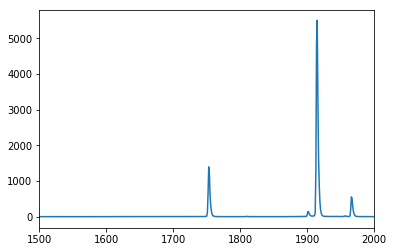

In [121]:
plt.plot(spectrum1D)
plt.xlim(1500,2000)
#plt.axvline(x=2253.4,c='r')

In [122]:
# set up calibration points

length = len(list1) 
cali1 = spectrum1D_list.index(list1[length-1])
cali2 = spectrum1D_list.index(list1[length-3])
cali3 = spectrum1D_list.index(list1[length-5])
cali4 = spectrum1D_list.index(list1[length-8])
cali5 = spectrum1D_list.index(list1[length-10])
cali6 = spectrum1D_list.index(list1[length-12])

cali7 = spectrum1D_list.index(list1[length-13])
cali8 = spectrum1D_list.index(list1[length-18])
cali9 = spectrum1D_list.index(list1[length-22])


or1 = 7032.413 #
or2 = 6402.246 #
or3 = 6678.276 #
or4 = 7245.167 #
or5 = 6506.528 #
or6 = 6143.062 #

or7 = 6382.991 #
or8 = 6334.428 # 
or9 = 6929.468 # 

x = np.array([cali1, cali2, cali3, cali4, cali5,
              cali6,cali7, cali8, cali9])
y = np.array([or1, or2, or3, or4, or5,or6,
             or7,or8,or9])
print(x)

[1915  937 1363 2253 1098  535  907  832 1753]


In [123]:
# Linear fit function

def linfit(xdata, ydata, yerror):
    def U(n):
        U_n = sum((xdata**n)/(yerror**2), 0)
        return U_n
    def W(n): 
        W_n = sum(ydata * (xdata**n) / (yerror**2)) 
        return W_n
    D = U(0) * U(2) - (U(1)**2)
    slope = (U(0)*W(1) - U(1)*W(0)) / D
    intercept = (U(2)*W(0) - U(1)*W(1)) / D
    sigma_slope = U(0)/D
    sigma_intercept = U(2)/D
    return slope, intercept

# Fitting slope and intercept

slope = linfit(x,y,1)[0]
inter = linfit(x,y,1)[1]

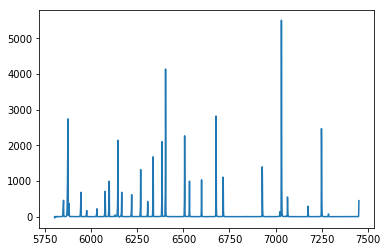

In [124]:
pixel = np.linspace(1,len(spectrum1D),len(spectrum1D))
cali = slope*pixel+inter

# spectrum with lines id

plt.plot(cali,spectrum1D)
plt.show()

y= 0.642814613386485 x+ 5800.269909667825


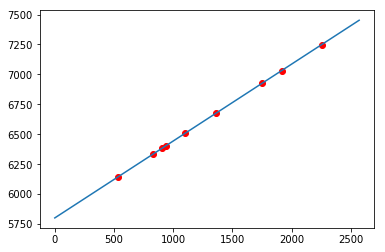

In [125]:
plt.plot(pixel,cali)
plt.scatter(x,y,c='r')
print("y=",slope,"x+",inter)